In [3]:
#All Libraries used in the code
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [4]:
#Reading the data from the csv files
hour3 = pd.read_csv('1_6pm - 9pm.csv')
hour6 = pd.read_csv('2_9pm - 12am.csv')
hour9 = pd.read_csv('3_12am - 3am.csv')
hour12 = pd.read_csv('4_3am - 6am.csv')
hour15 = pd.read_csv('5_6am - 9am.csv')
hour18 = pd.read_csv('6_9am - 12pm.csv')
hour21 = pd.read_csv('7_12pm - 3pm.csv')
hour24 = pd.read_csv('8_3pm - 6pm.csv')

hours = [hour3, hour6, hour9, hour12, hour15, hour18, hour21, hour24]

In [5]:
#Cleaning the data
for hour in hours:
    for column in hour.columns[1:]:
        hour[column] = pd.Series(hour[column]).dropna()


Mean Squared Error: 21.266870728225705


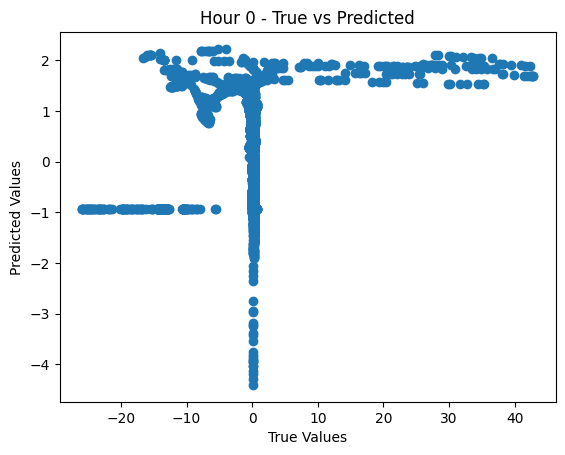

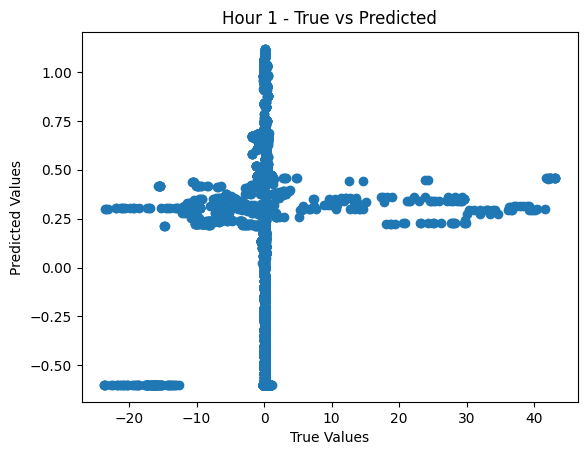

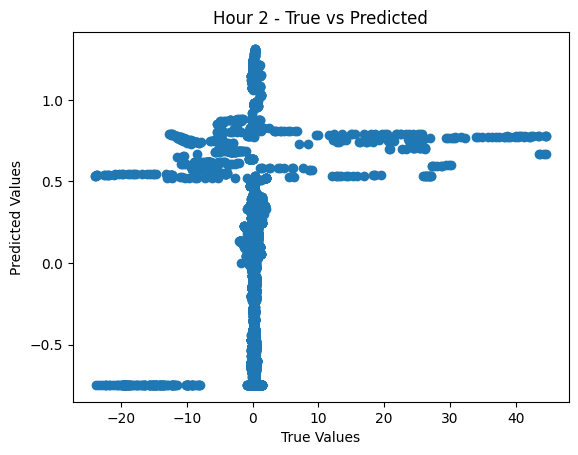

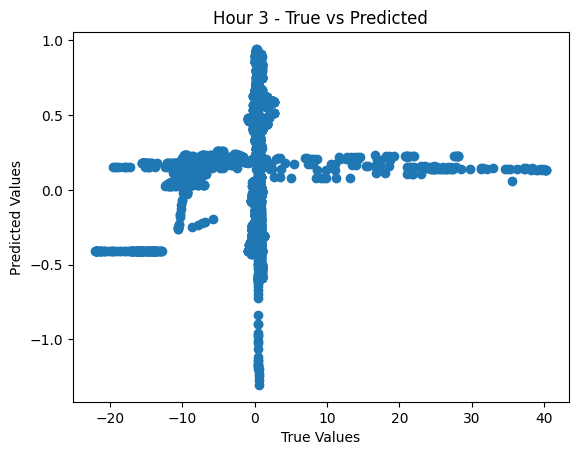

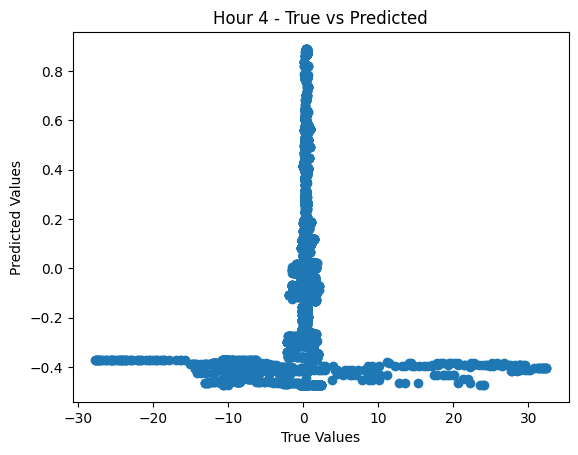

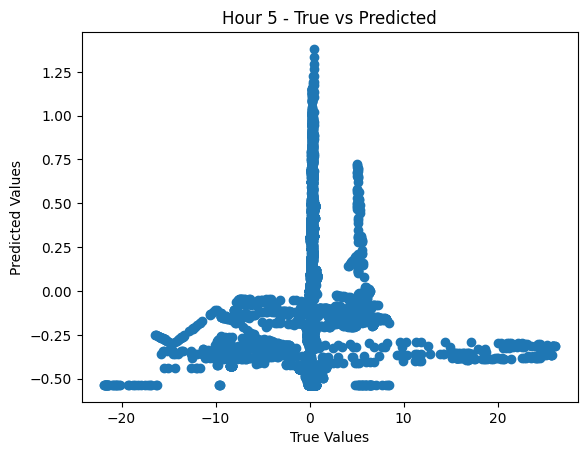

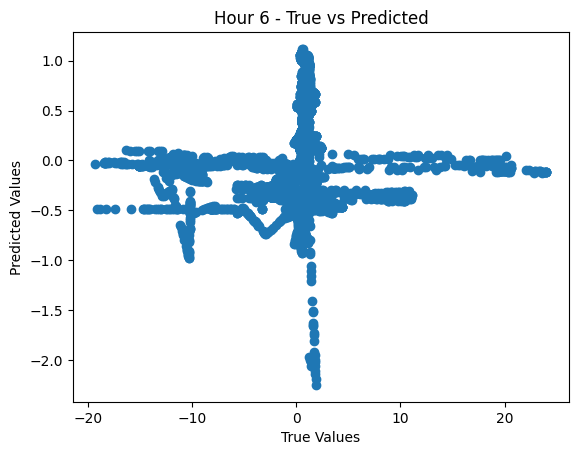

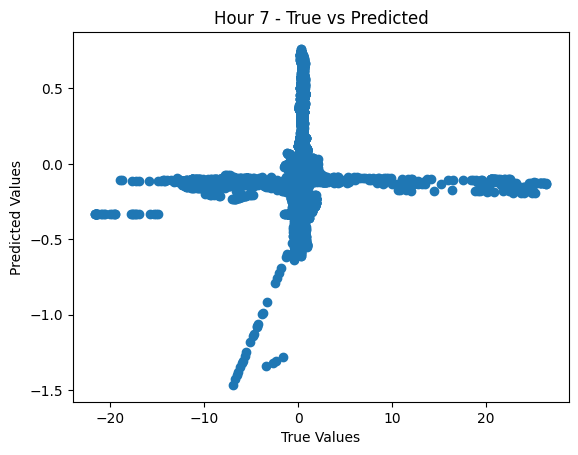

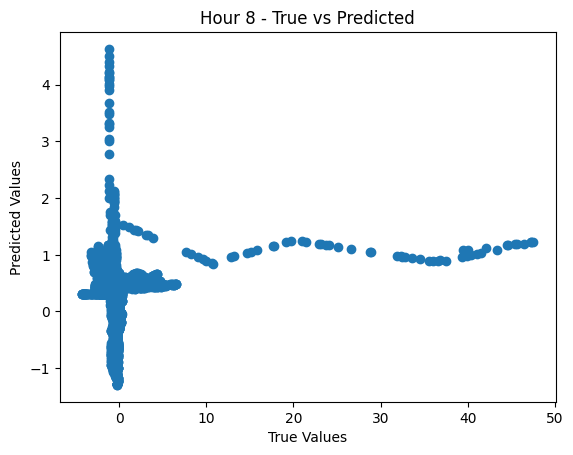

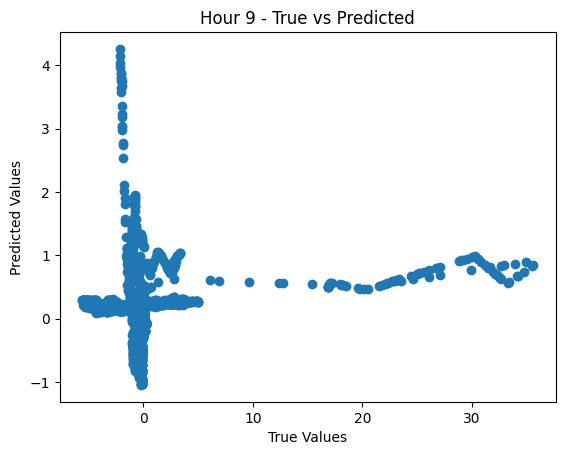

In [6]:
#AutoEncoder #1
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Define file paths
file_paths = [
    '1_6pm - 9pm.csv',
    '2_9pm - 12am.csv',
    '3_12am - 3am.csv',
    '4_3am - 6am.csv',
    '5_6am - 9am.csv',
    '6_9am - 12pm.csv',
    '7_12pm - 3pm.csv',
    '8_3pm - 6pm.csv'
]

# Load the data into dataframes
dataframes = [pd.read_csv(file) for file in file_paths]

# Combine the dataframes into a single dataframe
combined_data = pd.concat(dataframes, ignore_index=True)

# Extract frequency values
frequencies = combined_data['Freq_Hz'].values

# Extract amplitude values (each column represents a three-minute interval of amplitudes)
amplitude_columns = combined_data.columns[1:]
amplitudes = combined_data[amplitude_columns].values

# Handle NaN values by filling them with the mean of the column
amplitudes = np.nan_to_num(amplitudes, nan=np.nanmean(amplitudes))

# Standardize the data
scaler = StandardScaler()
amplitudes_scaled = scaler.fit_transform(amplitudes)

# Apply PCA
pca = PCA(n_components=10)  # Compress to 10 dimensions
compressed_representations = pca.fit_transform(amplitudes_scaled)

# Extract seen features (example: peak amplitudes and frequencies)
peak_amplitudes = amplitudes.max(axis=1)
peak_frequencies = frequencies[np.argmax(amplitudes, axis=1)]
seen_features = np.column_stack((peak_amplitudes, peak_frequencies))

# Split data
X_train, X_test, y_train, y_test = train_test_split(seen_features, compressed_representations, test_size=0.2, random_state=42)

# Train a regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Predict unseen features
y_pred = regressor.predict(X_test)

# Assess the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Scatter plot of true vs predicted compressed representations
for i in range(compressed_representations.shape[1]):
    plt.figure()
    plt.scatter(y_test[:, i], y_pred[:, i])
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Hour {i} - True vs Predicted')
    plt.show()

[[ 1.58861391 -2.18696971  0.564089   ... -1.29881001  2.25556773
  -0.9047383 ]
 [ 1.60210051 -2.18816379  0.56519323 ... -1.30036683  2.27869359
  -0.90581444]
 [ 1.61561927 -2.18936072  0.56630009 ... -1.30192737  2.30187458
  -0.90689314]
 ...
 [-0.42900411 -0.85887664 -0.83904904 ... -0.93590859 -0.97859482
  -0.76017719]
 [-0.43412063 -0.86034358 -0.84505362 ... -0.9390268  -0.98075297
  -0.76050359]
 [-0.43932137 -0.86171975 -0.85105757 ... -0.94211653 -0.98300194
  -0.76083726]]


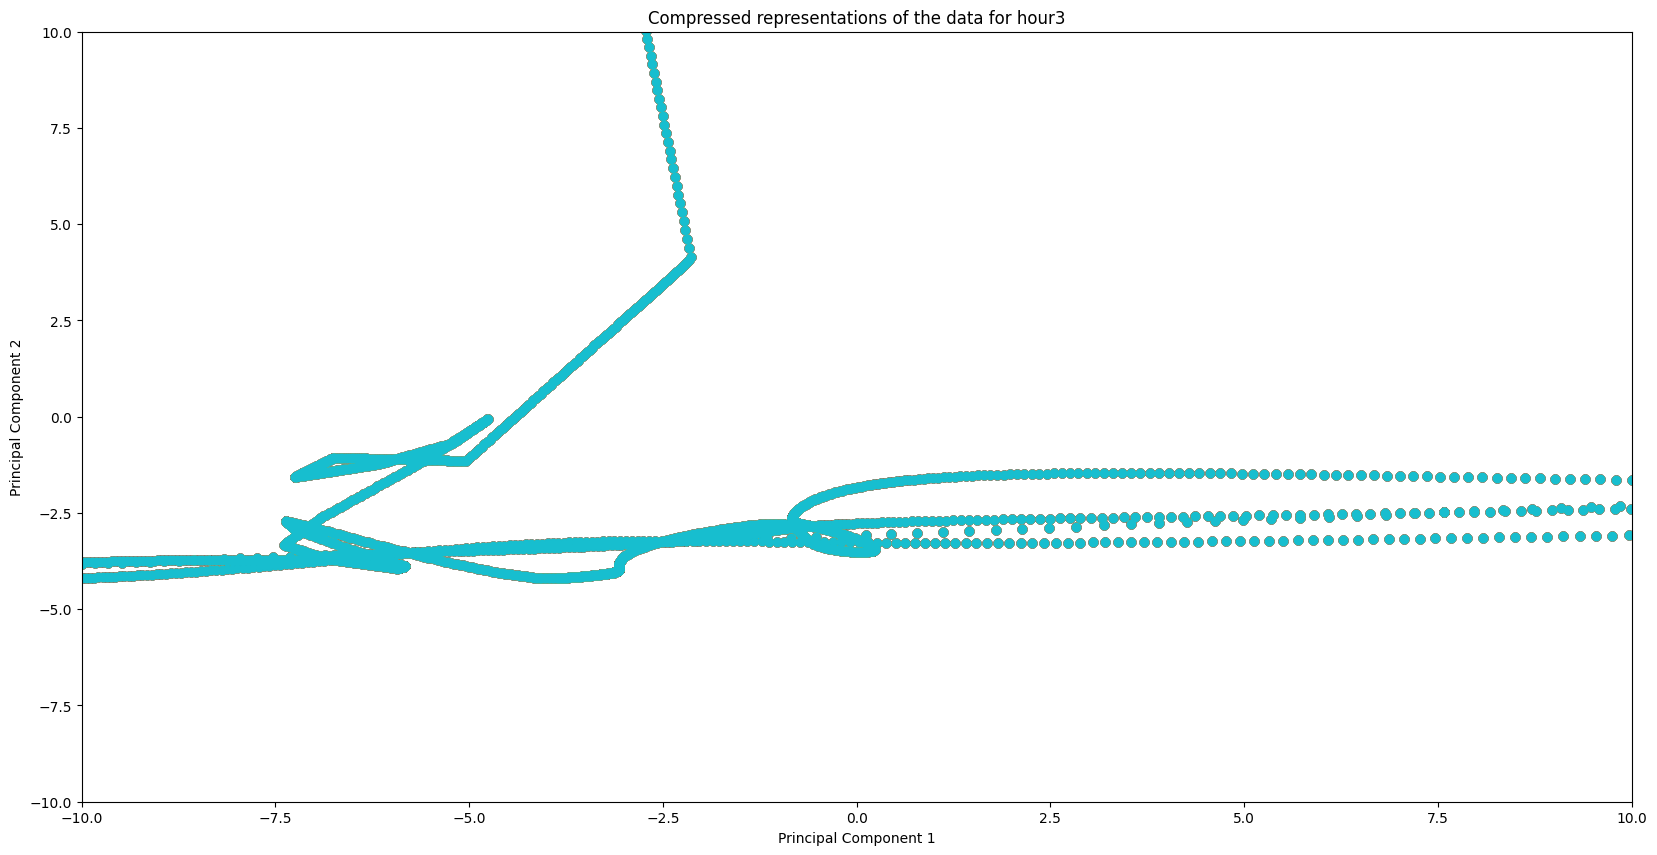

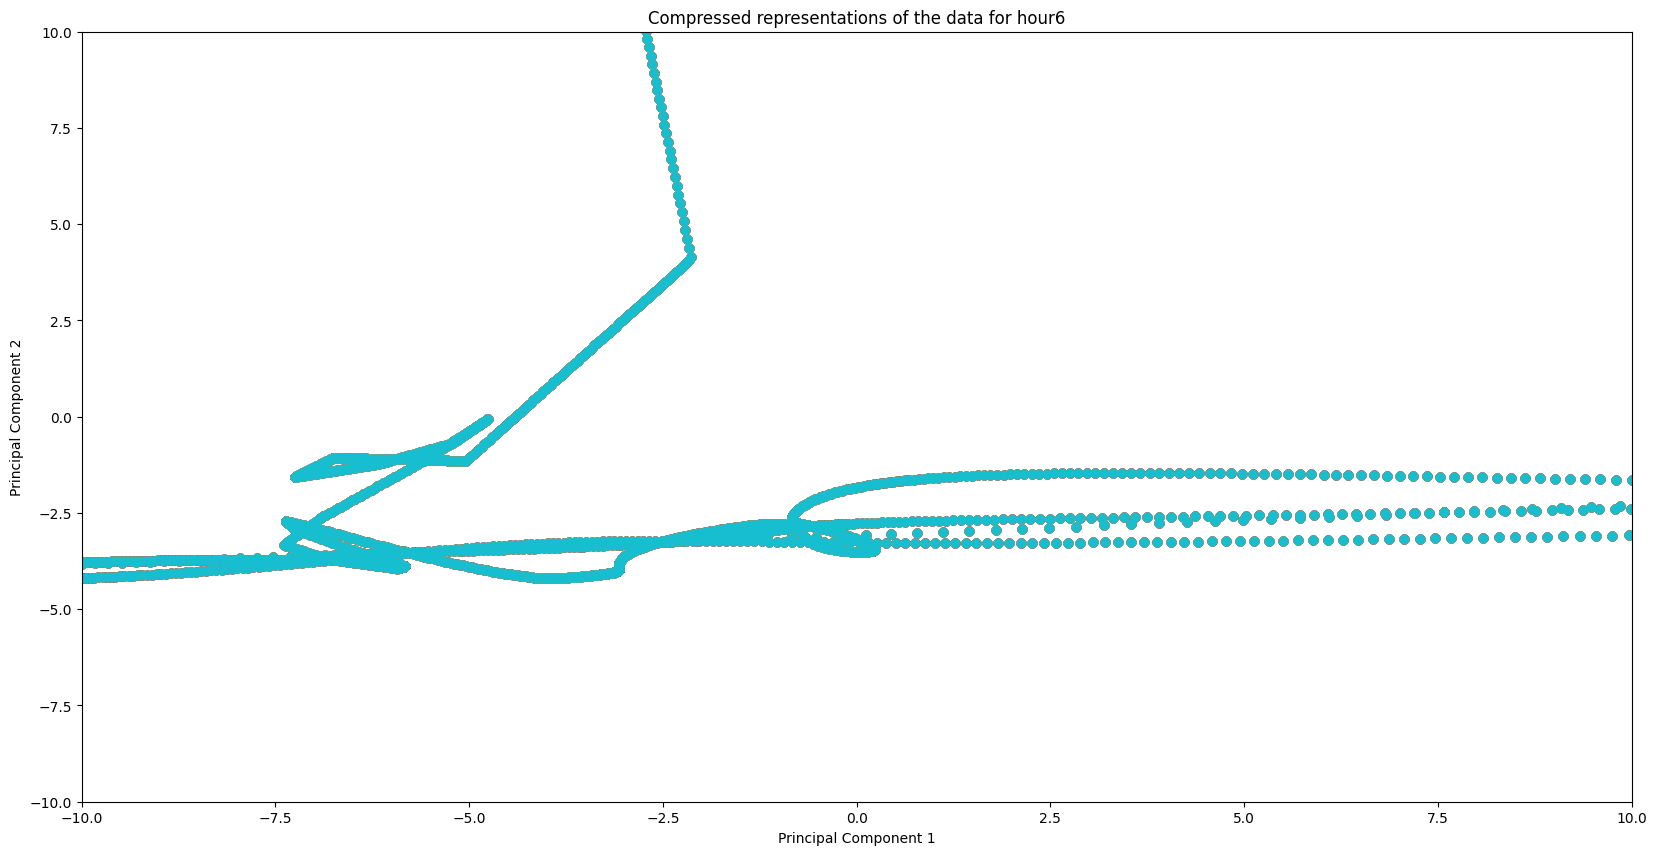

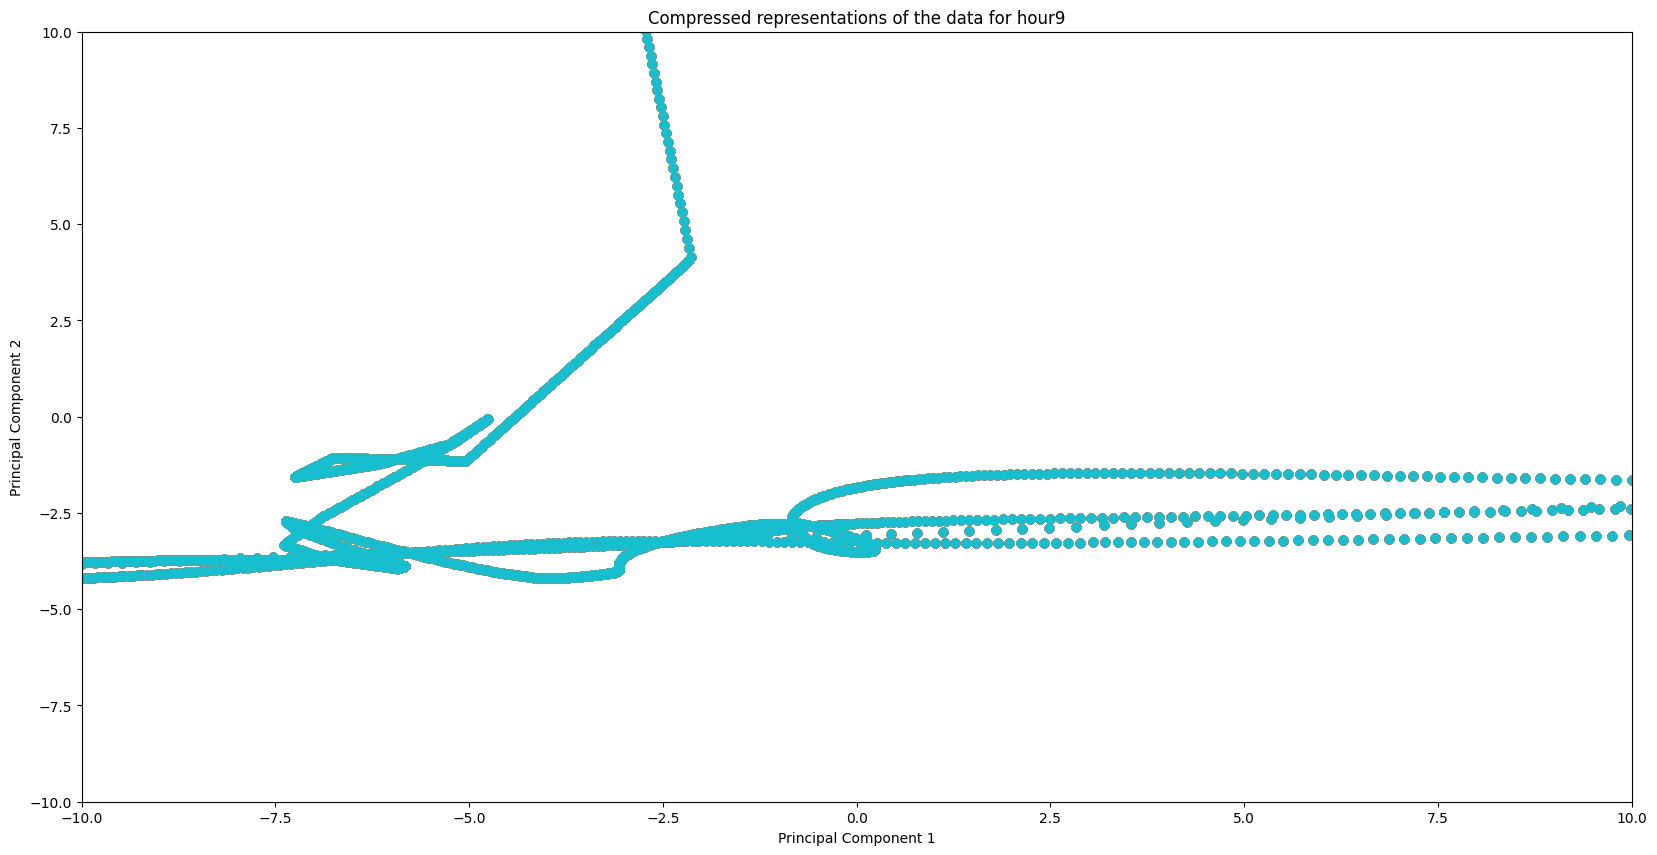

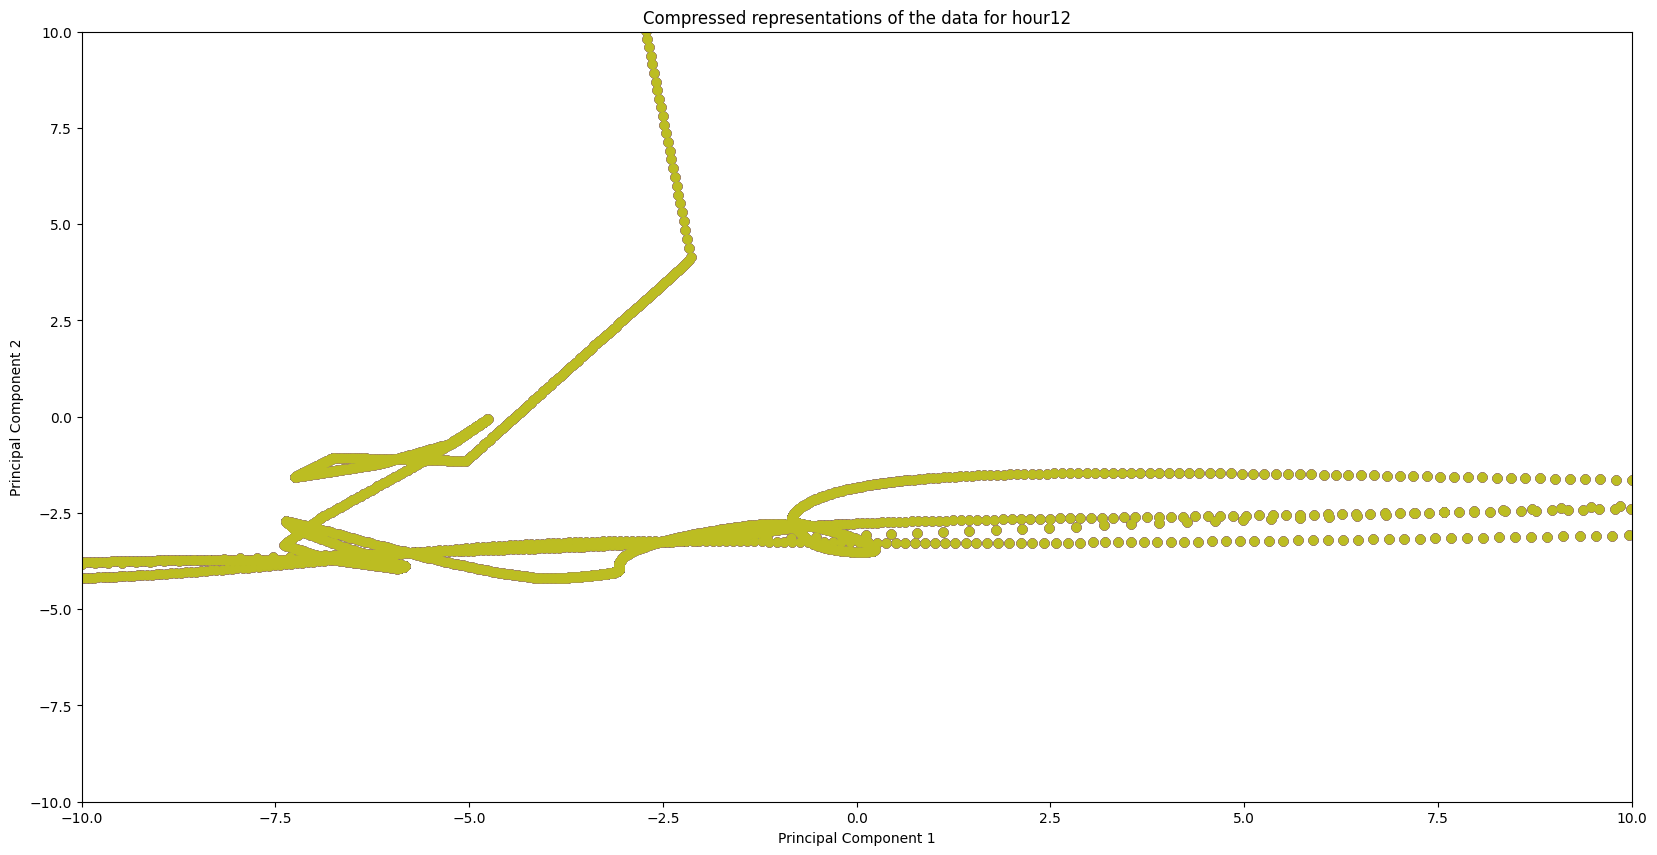

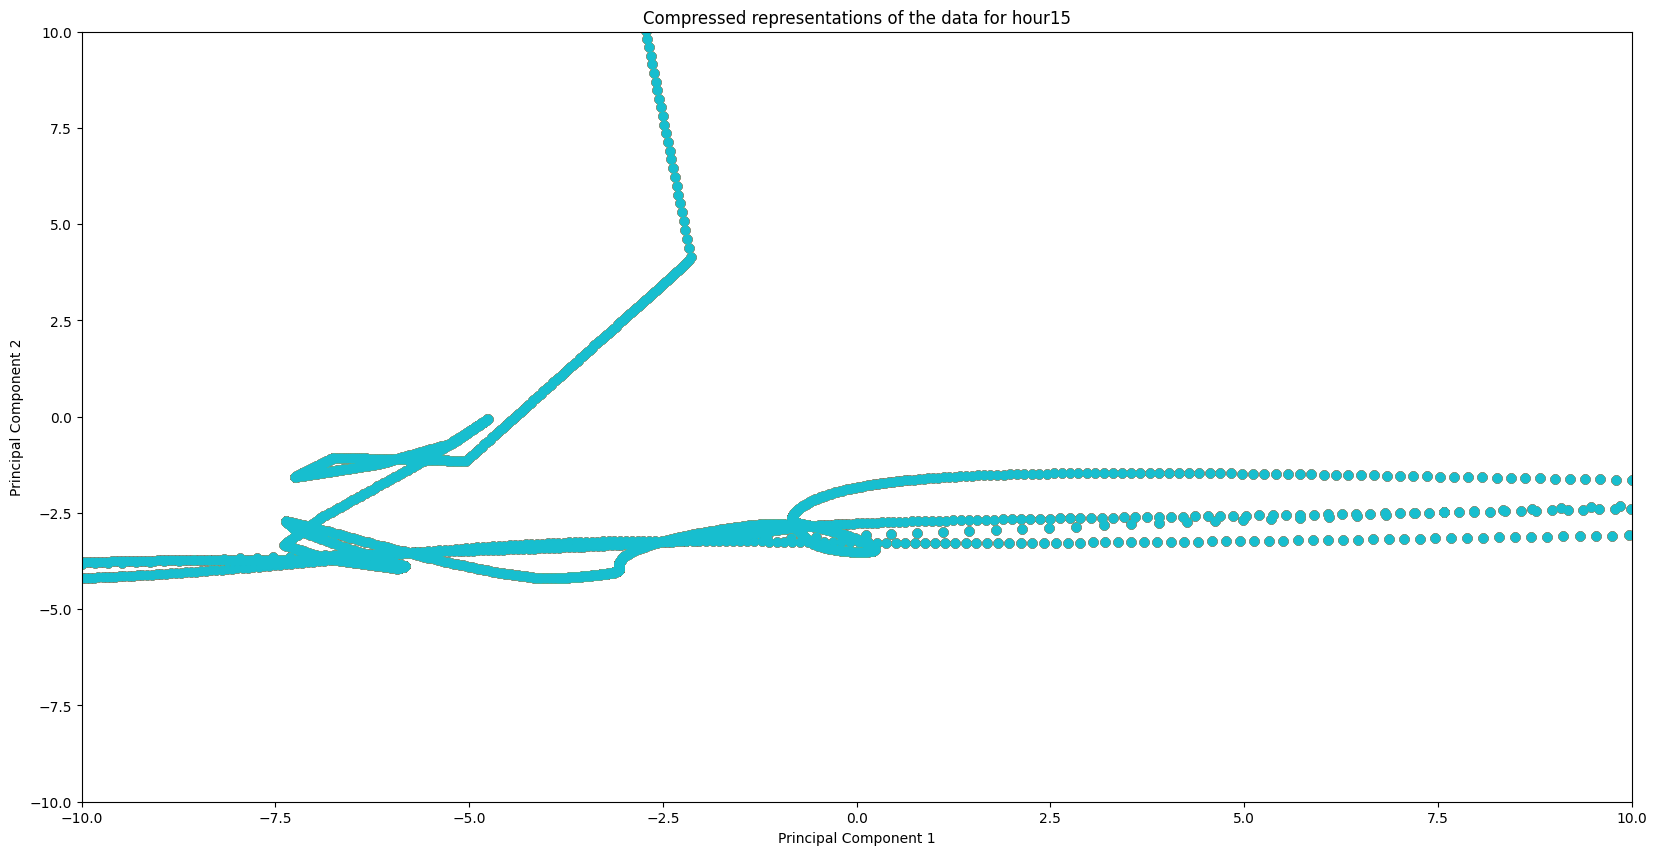

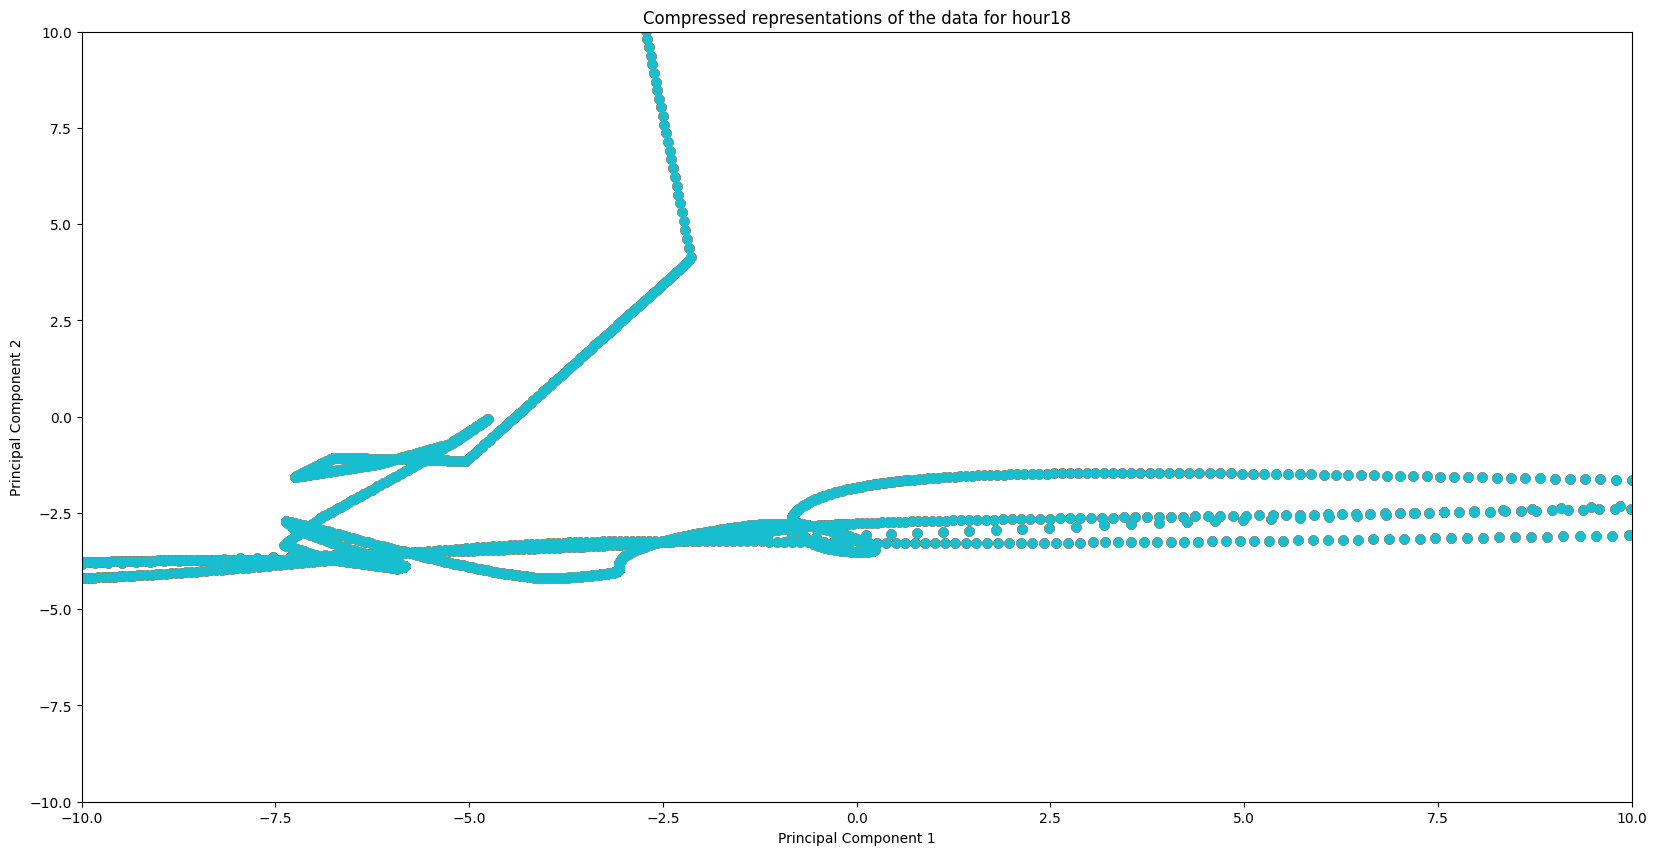

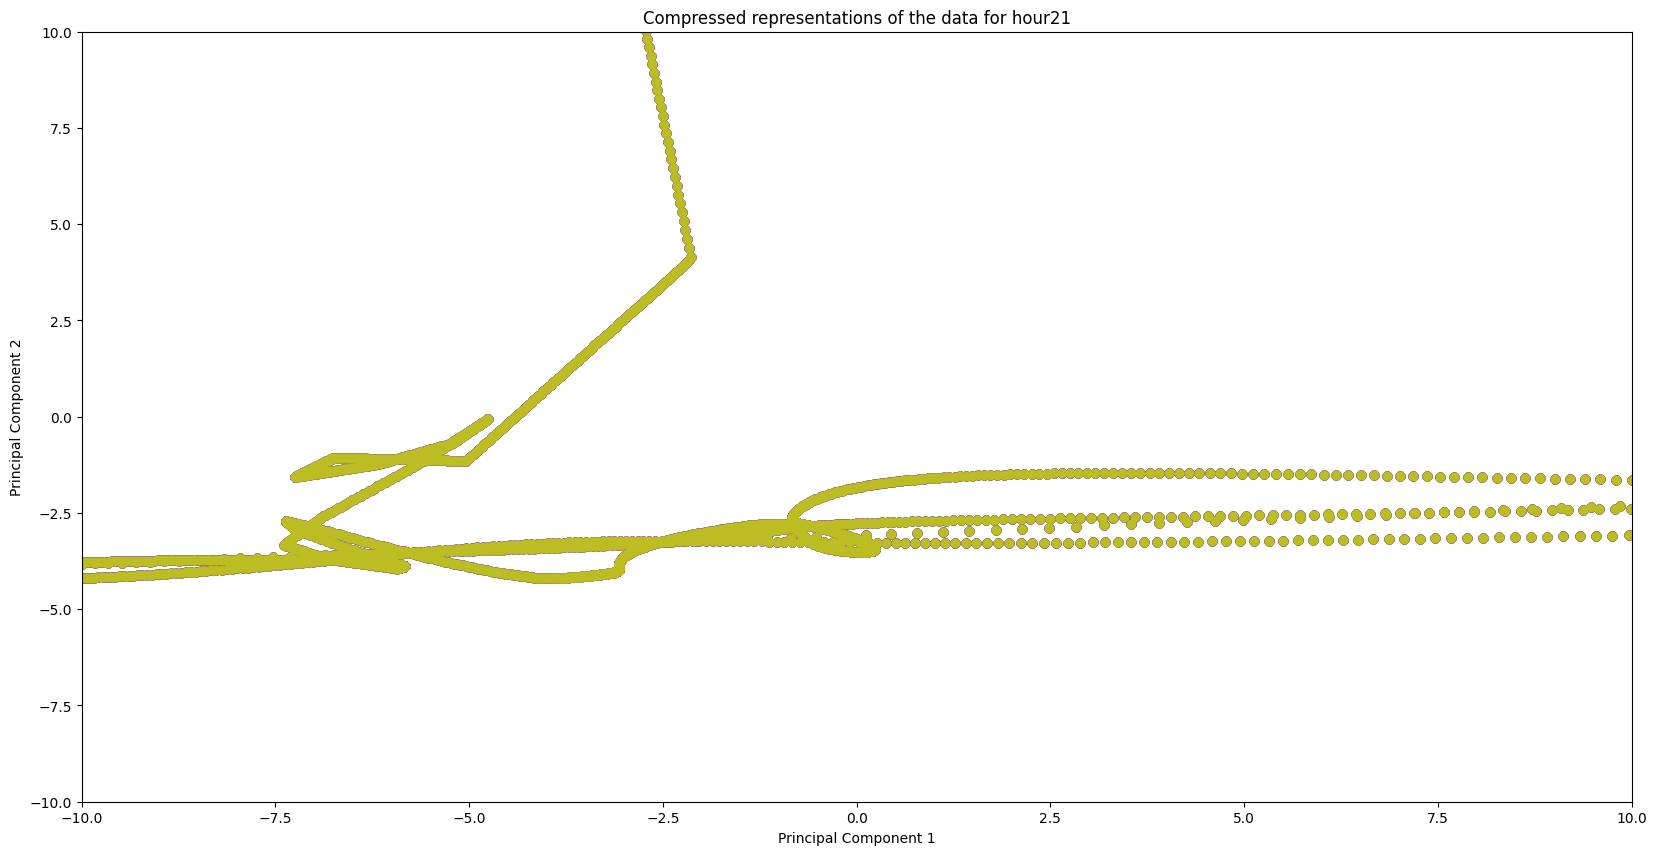

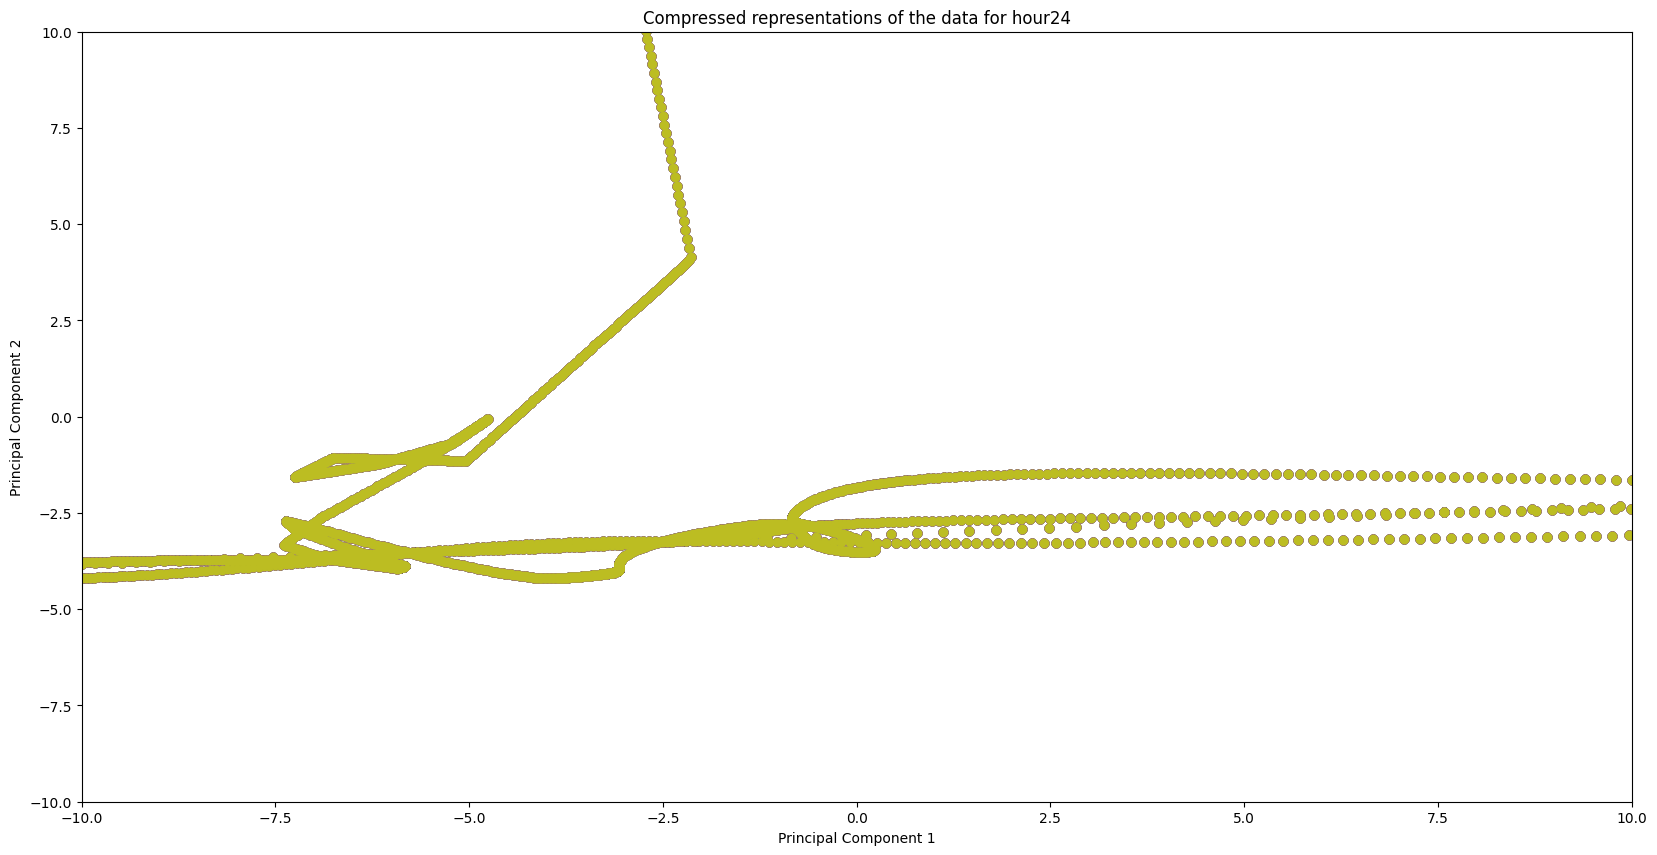

In [7]:
#Autoencoder #2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#Standardize the data
scaler = StandardScaler()
data = []
for hour in hours:
    for column in hour.columns[1:]:
        data.append(hour[column])
data = np.array(data)
data = data.transpose()
data = scaler.fit_transform(data)

#Check the data
print(data)

#Apply PCA
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(data)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

#Plot the compressed representations
i = 3
for hour in hours:
    plt.figure(figsize = (20, 10))
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    for column in hour.columns[1:]:
        plt.scatter(principalDf['principal component 1'], principalDf['principal component 2'])
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('Compressed representations of the data for hour' + str(i))
    plt.show
    i += 3

In [8]:
#Extract Seen Features
seen_features_dfs = {}
idx = 0
for idx, hour in enumerate(hours):
    features = []
    for column in hour.columns[1:]:
        curve = hour[column]
        peaks, _ = find_peaks(curve, height=0)
        peak_amplitudes = curve.iloc[peaks].values
        peak_frequencies = peaks
        area = np.trapz(curve)
        num_peaks = len(peaks)
        
        if len(peak_amplitudes) > 0:
            max_peak_amplitude = np.max(peak_amplitudes)
            avg_peak_frequency = np.mean(peak_frequencies)
        else:
            max_peak_amplitude = 0
            avg_peak_frequency = 0

        features.append({
            'column': column,
            'peak_amplitudes': peak_amplitudes,
            'peak_frequencies': peak_frequencies,
            'area_under_curve': area,
            'num_peaks': num_peaks
        })

    seen_features_dfs[f'df_{idx}'] = pd.DataFrame(features)